In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. DATA COLLECTION
print("Downloading stock data...")
ticker = "AAPL"  # Apple stock
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)  # 3 years of data

stock_data = yf.download(ticker, start=start_date, end=end_date)
print(f"Downloaded {len(stock_data)} days of data for {ticker}")

/tmp/ipykernel_9464/2435560015.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 751 days of data for AAPL


In [6]:
# 2. FEATURE ENGINEERING
df = stock_data.copy()

# Calculate technical indicators
df['Returns'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility'] = df['Returns'].rolling(window=20).std()
df['Volume_MA'] = df['Volume'].rolling(window=20).mean()

# Price momentum
df['Momentum'] = df['Close'] - df['Close'].shift(10)

# Target: Predict if price will go up (1) or down (0) in next day
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop NaN values
df.dropna(inplace=True)

# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 
            'MA_5', 'MA_20', 'Volatility', 'Volume_MA', 'Momentum']
X = df[features].values
y = df['Target'].values

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (731, 11), Target shape: (731,)


In [7]:
# 3. DATA PREPROCESSING
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False  # Don't shuffle time series
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 584, Test samples: 147


In [8]:
# 4. CREATE PYTORCH DATASET
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 5. BUILD NEURAL NETWORK MODEL
class StockPredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor(input_size=X_train.shape[1]).to(device)
print(f"\nUsing device: {device}")
print(f"Model architecture:\n{model}")


Using device: cuda
Model architecture:
StockPredictor(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [10]:
# 6. TRAINING SETUP
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. TRAINING LOOP
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("\nStarting training...")
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_train += (predictions == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    # Validation phase
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_test += (predictions == y_batch).sum().item()
            total_test += y_batch.size(0)
    
    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Starting training...
Epoch [10/50]
  Train Loss: 0.6891, Train Acc: 54.45%
  Test Loss: 0.6858, Test Acc: 55.10%
Epoch [20/50]
  Train Loss: 0.6886, Train Acc: 54.45%
  Test Loss: 0.6859, Test Acc: 55.10%
Epoch [30/50]
  Train Loss: 0.6876, Train Acc: 54.45%
  Test Loss: 0.6867, Test Acc: 55.10%
Epoch [40/50]
  Train Loss: 0.6894, Train Acc: 53.77%
  Test Loss: 0.6889, Test Acc: 55.10%
Epoch [50/50]
  Train Loss: 0.6859, Train Acc: 55.48%
  Test Loss: 0.6913, Test Acc: 54.42%



FINAL RESULTS
Final Train Accuracy: 55.48%
Final Test Accuracy: 54.42%

Training history saved as 'training_history.png'

Classification Report:
              precision    recall  f1-score   support

        Down       0.43      0.05      0.08        66
          Up       0.55      0.95      0.70        81

    accuracy                           0.54       147
   macro avg       0.49      0.50      0.39       147
weighted avg       0.50      0.54      0.42       147


Confusion Matrix:
TN: 3, FP: 63
FN: 4, TP: 77

Model saved as 'stock_predictor_model.pth'

Project complete!


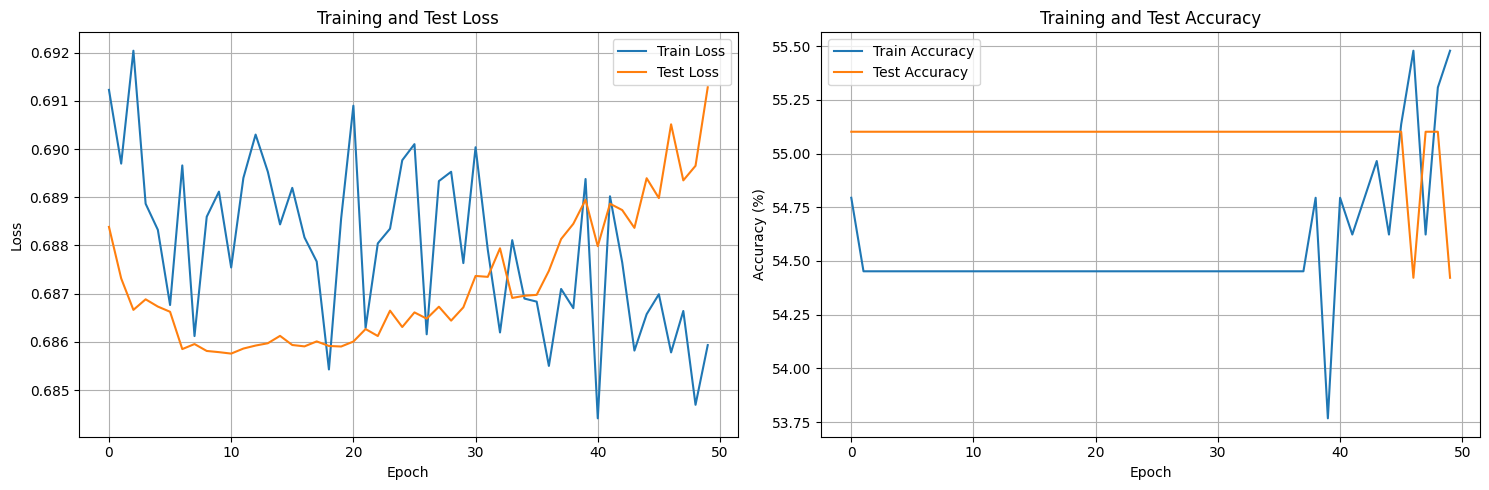

In [11]:
# 8. EVALUATION AND VISUALIZATION
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("\nTraining history saved as 'training_history.png'")

# 9. MAKE PREDICTIONS ON TEST SET
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_actuals.extend(y_batch.numpy())

# Calculate additional metrics

print("\nClassification Report:")
print(classification_report(all_actuals, all_predictions, 
                          target_names=['Down', 'Up']))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_actuals, all_predictions)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# 10. SAVE MODEL
torch.save(model.state_dict(), 'stock_predictor_model.pth')
print("\nModel saved as 'stock_predictor_model.pth'")

print("\n" + "="*50)
print("Project complete!")
print("="*50)